# Regression Models with cuML, scikit-learn, and XGBoost
This notebook demonstrates how to build and evaluate various regression models using cuML for GPU acceleration, scikit-learn for Partial Least Squares Regression, and XGBoost.

In [17]:
import copy
import numpy as np
import cuml
import cupy as cp
from cuml.linear_model import LinearRegression as cuLinearRegression
from cuml.linear_model import Lasso as cuLasso
from cuml.linear_model import Ridge as cuRidge
from cuml.linear_model import ElasticNet as cuElasticNet
from cuml.svm import SVR as cuSVR
from cuml.ensemble import RandomForestRegressor as cuRF
from cuml.neighbors import KNeighborsRegressor as cuKNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split as TTS
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LassoCV 
from sklearn.feature_selection import SelectFromModel
import os
os.chdir("/local-scratch/GlucoseProject/mobicom23_mobispectral/regression")
import sys
sys.path.append(os.getcwd())
from utils import *
from evaluate import *

In [2]:
data_root = '../datasets/dataset_skin/regression'
file_train = 'concatset_train.txt'
file_test = 'concatset_test.txt'
step = 1

In [19]:
data_root = '../datasets/dataset_glucose/Hyperspectral'
file_train = 'train_data.txt'
file_test = 'test_data.txt'
step = 11

In [2]:
data_root = '../datasets/dataset_glucose/Hyperspectral'
file_name = 'labels_hs.csv'
step = 1

In [20]:
X_train, y_train, X_test, y_test, test_data = prepare_data(data_root, file_train, file_test, step)
# X_train, X_val, y_train, y_val = TTS(X_train, y_train, test_size=0.3, random_state=42)

In [4]:
X, y, test_data = prepare_data2(data_root, file_name, step)
X_train, X_test, y_train, y_test = TTS(X, y, test_size=0.3, random_state=42)

In [21]:
# scaler = MinMaxScaler()
scaler = RobustScaler()
# scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [22]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(105625, 19) (105625,) (46475, 19) (46475,)


In [ ]:
# Fit LassoCV model 
lasso_cv = LassoCV(cv=10, random_state=42, verbose=True, alphas=[0.0001, 0.001, 0.01, 0.1, 1, 5], n_jobs=-1)
lasso_cv.fit(X_train, y_train)

print("LassoCV model fit complete...")
# Feature selection 
sfm = SelectFromModel(lasso_cv, prefit=True, threshold=25) 
X_train = sfm.transform(X_train) 
X_val = sfm.transform(X_val)
X_test = sfm.transform(X_test)

# Show dimensions of data after LassoCV
print("X_train_selected shape: ", X_train.shape)
print("X_val_selected shape: ", X_val.shape)
print("X_test_selected shape: ", X_test.shape)

feature_indices = np.array(range(len(lasso_cv.coef_)))

# Analyze selected features and their importance 
selected_feature_indices = np.where(sfm.get_support())[0] 
selected_features = feature_indices[selected_feature_indices] 
coefficients = lasso_cv.coef_ 
print("Selected Features:", selected_features) 
print("Feature Coefficients:", coefficients) 

In [9]:
# Step 1, 80 features selected, F score
selected_features_indices = [  1,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,
  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81, 143, 145, 149, 150, 151, 152,
 153, 154, 155, 156, 157, 158, 162, 163]
X_train_selected = X_train[:, selected_features_indices]
# X_val_selected = X_val[:, selected_features_indices]
X_test_selected = X_test[:, selected_features_indices]

test_data_selected = copy.deepcopy(test_data)

for image in test_data_selected:
    test_features = image['sig']
    test_features = scaler.transform(test_features)
    image['sig'] = test_features[:, selected_features_indices]

In [10]:
# Step 1, 50 features selected, F score, standard scaler, with x_val
# Step 1, 50 features selected, F score, robust scaler, without x_val (Same as above!)
selected_features_indices = [ 1, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
 67, 68]
X_train_selected = X_train[:, selected_features_indices]
# X_val_selected = X_val[:, selected_features_indices]
X_test_selected = X_test[:, selected_features_indices]

test_data_selected = copy.deepcopy(test_data)

for image in test_data_selected:
    test_features = image['sig']
    test_features = scaler.transform(test_features)
    image['sig'] = test_features[:, selected_features_indices]

In [7]:
# Step 1, 50 features selected, XGBoost
selected_features_indices = [ 83,  63,  61,  20, 101,  65,   4,   3,   5,  19,   1, 161,  62,   0,   2,  16,   9, 195, 136,  64,  21, 199,  90,  15, 184, 186, 197,   8, 153, 115, 203,  95, 110,  69,   6, 192, 18, 162,  17, 183,  24, 202, 193,  92,  37, 169, 172, 157, 154,  23]
X_train_selected = X_train[:, selected_features_indices]
# X_val_selected = X_val[:, selected_features_indices]
X_test_selected = X_test[:, selected_features_indices]

test_data_selected = copy.deepcopy(test_data)


for image in test_data_selected:
    test_features = image['sig']
    test_features = scaler.transform(test_features)
    image['sig'] = test_features[:, selected_features_indices]

In [5]:
# Step 1, 50 features selected, Lasso
selected_features_indices = [23,  24,  27,  31,  49,  50,  52,  57,  58,  63,  68,  75,  76,  78,  90,  94,  99, 101, 105, 106, 110, 111, 121, 127, 128, 129, 131, 133, 136, 138, 144, 145, 146, 150, 151, 159, 162, 165, 166, 168, 169, 170, 173, 177, 178, 179, 188, 192, 193, 195]
X_train_selected = X_train[:, selected_features_indices]
# X_val_selected = X_val[:, selected_features_indices]
X_test_selected = X_test[:, selected_features_indices]

test_data_selected = copy.deepcopy(test_data)


for image in test_data_selected:
    test_features = image['sig']
    test_features = scaler.transform(test_features)
    image['sig'] = test_features[:, selected_features_indices]

In [7]:
# Step 1, 49 features selected, F score
selected_features_indices = [1, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68]
X_train_selected = X_train[:, selected_features_indices]
# X_val_selected = X_val[:, selected_features_indices]
X_test_selected = X_test[:, selected_features_indices]

test_data_selected = copy.deepcopy(test_data)

for image in test_data_selected:
    test_features = image['sig']
    test_features = scaler.transform(test_features)
    image['sig'] = test_features[:, selected_features_indices]

In [5]:
# Step 1, 48 features selected, F score
selected_features_indices = [21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68]
X_train_selected = X_train[:, selected_features_indices]
# X_val_selected = X_val[:, selected_features_indices]
X_test_selected = X_test[:, selected_features_indices]

test_data_selected = copy.deepcopy(test_data)

for image in test_data_selected:
    test_features = image['sig']
    test_features = scaler.transform(test_features)
    image['sig'] = test_features[:, selected_features_indices]

In [17]:
# Step 1, 45 features selected, F score
selected_features_indices = [21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 38, 39, 41, 42, 43, 44, 45, 46, 47,
 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68]
X_train_selected = X_train[:, selected_features_indices]
# X_val_selected = X_val[:, selected_features_indices]
X_test_selected = X_test[:, selected_features_indices]

test_data_selected = copy.deepcopy(test_data)


for image in test_data_selected:
    test_features = image['sig']
    test_features = scaler.transform(test_features)
    image['sig'] = test_features[:, selected_features_indices]

In [12]:
# Step 1, 40 features selected, F score
selected_features_indices = [21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]
X_train_selected = X_train[:, selected_features_indices]
# X_val_selected = X_val[:, selected_features_indices]
X_test_selected = X_test[:, selected_features_indices]

test_data_selected = copy.deepcopy(test_data)


for image in test_data_selected:
    test_features = image['sig']
    test_features = scaler.transform(test_features)
    image['sig'] = test_features[:, selected_features_indices]

In [97]:
print(X_train_selected.shape)

(4088984, 50)


In [10]:
# Step 1, 20 features selected Lasso
selected_features_indices = [ 23,  24,  52,  58,  68,  76,  99, 105, 106, 127, 129, 133, 144, 145, 146, 162, 169, 177,
 179, 195]
X_train_selected = X_train[:, selected_features_indices]
# X_val_selected = X_val[:, selected_features_indices]
X_test_selected = X_test[:, selected_features_indices]

test_data_selected = copy.deepcopy(test_data)

for image in test_data_selected:
    test_features = image['sig']
    test_features = scaler.transform(test_features)
    image['sig'] = test_features[:, selected_features_indices]

In [174]:
# Step 1, Threshold 30, 8 features selected
selected_features_indices = [ 68,  99, 106, 127, 129, 146, 177, 179]
X_train_selected = X_train[:, selected_features_indices]
X_val_selected = X_val[:, selected_features_indices]
X_test_selected = X_test[:, selected_features_indices]

test_data_selected = copy.deepcopy(test_data)


for image in test_data_selected:
    test_features = image['sig']
    test_features = scaler.transform(test_features)
    image['sig'] = test_features[:, selected_features_indices]

In [23]:
for image in test_data:
    image['sig'] = scaler.transform(image['sig'])
    

## PCR (PCA + Linear Regression)

ARD by signatures: 0.14953312277793884


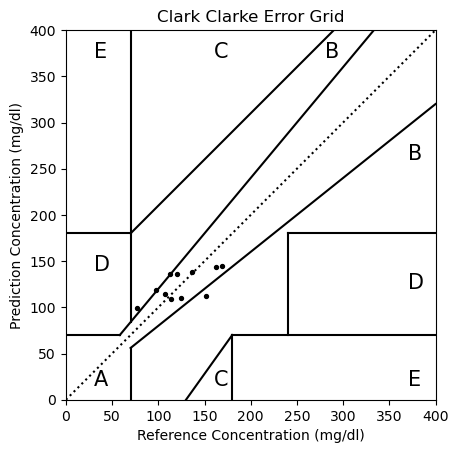

ARD by images:  [0.22094287 0.11826027 0.11090384 0.14817283 0.06564729 0.00812835
 0.26044494 0.03803142 0.13065241 0.2897639  0.2035214 ]
Average ARD:  0.14495178


In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
pcr = make_pipeline(StandardScaler(), PCA(n_components=25), LinearRegression())
pcr.fit(X_train, y_train)
y_pred_pcr = cp.asnumpy(pcr.predict(X_test))
mse_pcr = mean_squared_error(y_test, y_pred_pcr)
print(f"ARD by signatures: {ARD(y_pred_pcr, y_test).mean()}" )
evaluate_image(test_data, model=pcr)
ard = ard_image(test_data, pcr)
print("ARD by images: ", ard)
print("Average ARD: ", ard.mean())

In [6]:
X_train = cp.array(X_train)
# X_val = cp.array(X_val)
X_test = cp.array(X_test)

In [6]:
X_train_selected = cp.array(X_train_selected)
# X_val_selected = cp.array(X_val_selected)
X_test_selected = cp.array(X_test_selected)

ARD by signatures: 0.1632164567708969


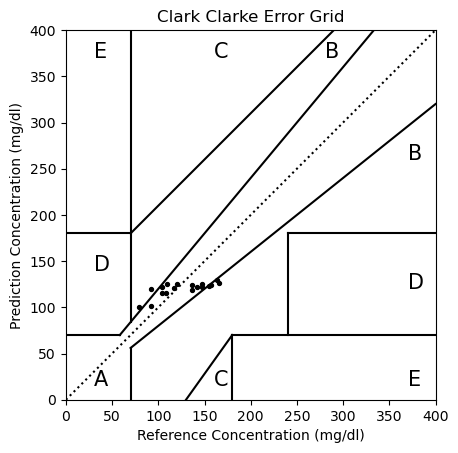

ARD by images:  [0.23525983 0.13761395 0.03560624 0.09025544 0.15389454 0.20562951
 0.30336538 0.16254476 0.20677212 0.26775327 0.10296254 0.13364145
 0.14627783 0.20241086 0.17687652 0.02945574 0.10459314 0.07186934]
Average ARD:  0.15371014


In [22]:
# Linear Regression
# 49 bands, F score
lin_reg = cuLinearRegression()
lin_reg.fit(X_train_selected, y_train)
y_pred_lin = cp.asnumpy(lin_reg.predict(X_test_selected))
mse_lin = mean_squared_error(y_test, y_pred_lin)
print(f"ARD by signatures: {ARD(y_pred_lin, y_test).mean()}" )
evaluate_image(test_data_selected, model=lin_reg)
ard = ard_image(test_data_selected, lin_reg)
print("ARD by images: ", ard)
print("Average ARD: ", ard.mean())

ARD by signatures: 0.1639443188905716


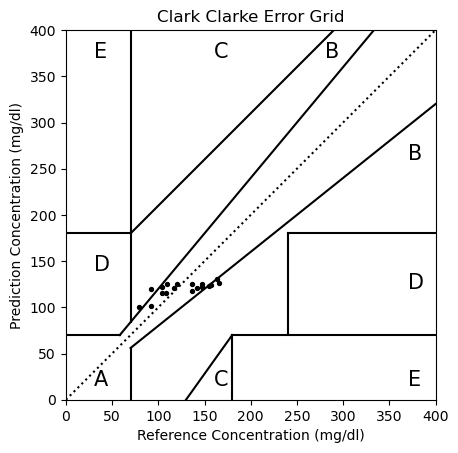

ARD by images:  [0.23537287 0.13843152 0.03652413 0.08911196 0.15253213 0.20554288
 0.30219156 0.16665652 0.20374261 0.26504245 0.09863851 0.13799801
 0.14769337 0.20261705 0.17727278 0.0278204  0.10149993 0.06996462]
Average ARD:  0.15325852


In [6]:
# Linear Regression
# 50 bands, XGBoost
lin_reg = cuLinearRegression()
lin_reg.fit(X_train_selected, y_train)
y_pred_lin = cp.asnumpy(lin_reg.predict(X_test_selected))
mse_lin = mean_squared_error(y_test, y_pred_lin)
print(f"ARD by signatures: {ARD(y_pred_lin, y_test).mean()}" )
evaluate_image(test_data_selected, model=lin_reg)
ard = ard_image(test_data_selected, lin_reg)
print("ARD by images: ", ard)
print("Average ARD: ", ard.mean())

ARD by signatures: 0.17605537176132202


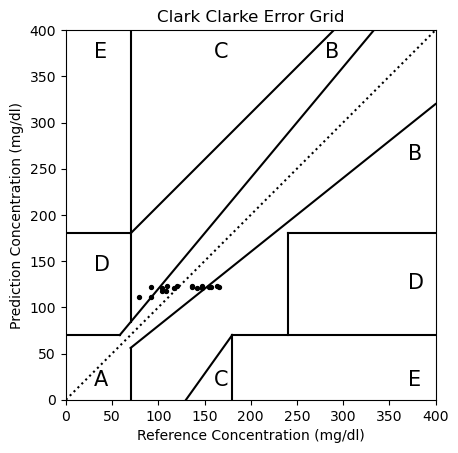

ARD by images:  [0.26599872 0.12085415 0.01650083 0.10043412 0.1646627  0.21859159
 0.32358783 0.15543017 0.25014028 0.39603686 0.21530215 0.10866176
 0.14830507 0.21320243 0.17800175 0.03014899 0.12623312 0.08981574]
Average ARD:  0.17343934


In [23]:
# Lasso Regression
# 50 bands, F score
lasso_reg = cuLasso()
lasso_reg.fit(X_train_selected, y_train)
y_pred_lasso = cp.asnumpy(lasso_reg.predict(X_test_selected))
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
print(f"ARD by signatures: {ARD(y_pred_lasso, y_test).mean()}" )
evaluate_image(test_data_selected, model=lasso_reg)
ard = ard_image(test_data_selected, lasso_reg)
print("ARD by images: ", ard)
print("Average ARD: ", ard.mean())

ARD by signatures: 0.17762979865074158


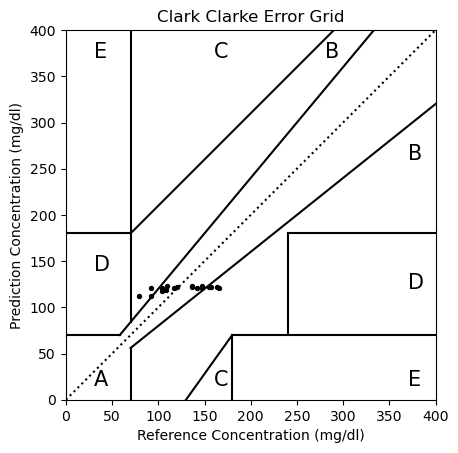

ARD by images:  [0.26738137 0.1152586  0.01198299 0.10481654 0.16893958 0.22198524
 0.31920528 0.15535483 0.2533481  0.40985686 0.22305246 0.10995867
 0.14867158 0.21402241 0.17863744 0.02986021 0.13051754 0.09382708]
Average ARD:  0.17537092


In [7]:
# Lasso Regression
# 50 bands, XGBoost
lasso_reg = cuLasso()
lasso_reg.fit(X_train_selected, y_train)
y_pred_lasso = cp.asnumpy(lasso_reg.predict(X_test_selected))
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
print(f"ARD by signatures: {ARD(y_pred_lasso, y_test).mean()}" )
evaluate_image(test_data_selected, model=lasso_reg)
ard = ard_image(test_data_selected, lasso_reg)
print("ARD by images: ", ard)
print("Average ARD: ", ard.mean())

ARD by signatures: 0.1632189154624939


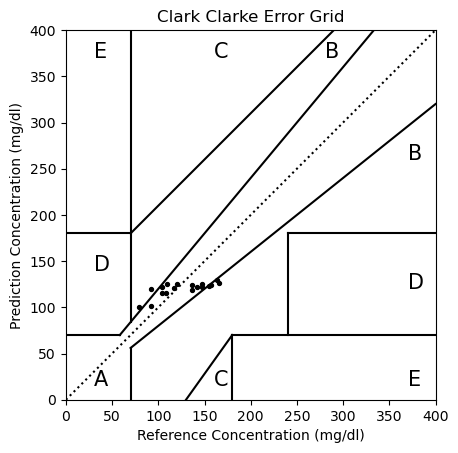

ARD by images:  [0.23525427 0.13763165 0.03562697 0.09023912 0.15388007 0.20561607
 0.3033941  0.16255148 0.20676216 0.26773998 0.10296096 0.13364825
 0.14628989 0.20242721 0.1768922  0.02944297 0.10458817 0.07186207]
Average ARD:  0.15371153


In [24]:
# Ridge Regression
ridge_reg = cuRidge()
ridge_reg.fit(X_train_selected, y_train)
y_pred_ridge = cp.asnumpy(ridge_reg.predict(X_test_selected))
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
print(f"ARD by signatures: {ARD(y_pred_ridge, y_test).mean()}" )
evaluate_image(test_data_selected, model=ridge_reg)
ard = ard_image(test_data_selected, ridge_reg)
print("ARD by images: ", ard)
print("Average ARD: ", ard.mean())

ARD by signatures: 0.17831462621688843


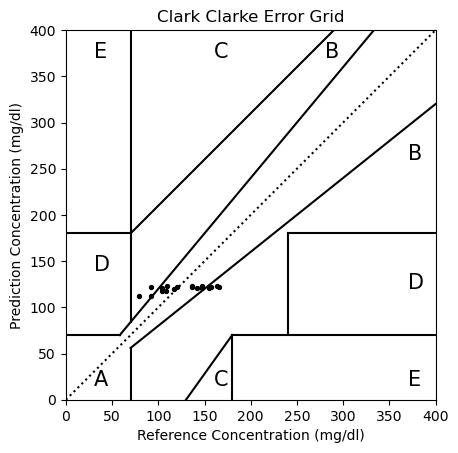

ARD by images:  [0.26677248 0.1167029  0.01356705 0.10303174 0.16814296 0.22028169
 0.32333454 0.15584074 0.25112718 0.41469547 0.22500496 0.11136105
 0.15139861 0.21768421 0.18207547 0.0268873  0.12822862 0.09024749]
Average ARD:  0.17591025


In [26]:
# Elastic Net
elastic_net = cuElasticNet()
elastic_net.fit(X_train_selected, y_train)
y_pred_elastic = cp.asnumpy(elastic_net.predict(X_test_selected))
mse_elastic = mean_squared_error(y_test, y_pred_elastic)
print(f"ARD by signatures: {ARD(y_pred_elastic, y_test).mean()}" )
evaluate_image(test_data_selected, model=elastic_net)
ard = ard_image(test_data_selected, elastic_net)
print("ARD by images: ", ard)
print("Average ARD: ", ard.mean())

ARD by signatures: 0.13197410106658936


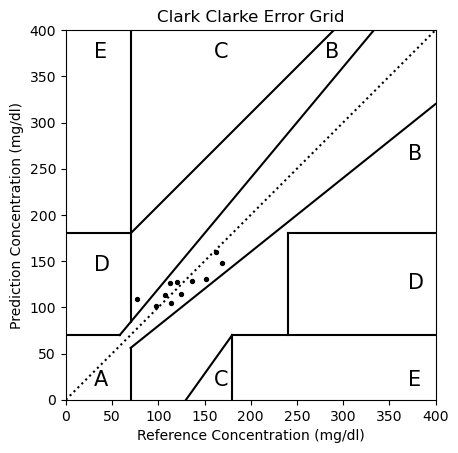

ARD by images:  [0.04709905 0.01742118 0.08389883 0.12728688 0.05544408 0.06013868
 0.13405259 0.07747526 0.057847   0.41433248 0.12191893]
Average ARD:  0.108810455


In [9]:
# Multi-Layer Perceptron
mlp_reg = MLPRegressor()
mlp_reg.fit(cp.asnumpy(X_train), cp.asnumpy(y_train))
y_pred_mlp = cp.asnumpy(mlp_reg.predict(X_test))
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
print(f"ARD by signatures: {ARD(y_pred_mlp, y_test).mean()}" )
evaluate_image(test_data, model=mlp_reg)
ard = ard_image(test_data, mlp_reg)
print("ARD by images: ", ard)
print("Average ARD: ", ard.mean())

ARD by signatures: 0.16489751636981964


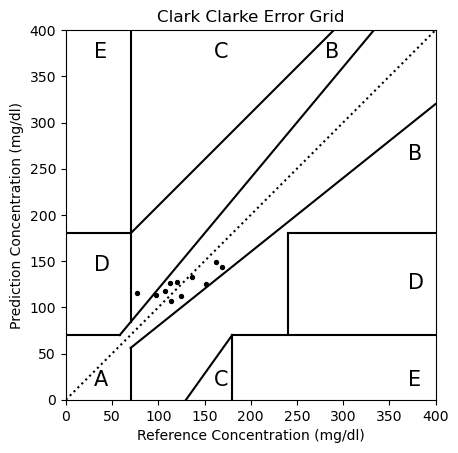

ARD by images:  [0.16959856 0.08612213 0.09459159 0.15194628 0.08879547 0.03339347
 0.17096616 0.05653108 0.0631313  0.4940164  0.11402612]
Average ARD:  0.13846532


In [10]:
# KNN
knn_reg = cuKNeighborsRegressor()
knn_reg.fit(X_train, y_train)
y_pred_knn = cp.asnumpy(knn_reg.predict(X_test))
mse_knn = mean_squared_error(y_test, y_pred_knn)
print(f"ARD by signatures: {ARD(y_pred_knn, y_test).mean()}" )
evaluate_image(test_data, model=knn_reg)
ard = ard_image(test_data, knn_reg)
print("ARD by images: ", ard)
print("Average ARD: ", ard.mean())

In [ ]:
# KNN
# 50 bands, F score
knn_reg = cuKNeighborsRegressor()
knn_reg.fit(X_train_selected, y_train)
y_pred_knn = cp.asnumpy(knn_reg.predict(X_test_selected))
mse_knn = mean_squared_error(y_test, y_pred_knn)
print(f"ARD by signatures: {ARD(y_pred_knn, y_test).mean()}" )
evaluate_image(test_data_selected, model=knn_reg)
ard = ard_image(test_data_selected, knn_reg)
print("ARD by images: ", ard)
print("Average ARD: ", ard.mean())

ARD by signatures: 0.14488069713115692


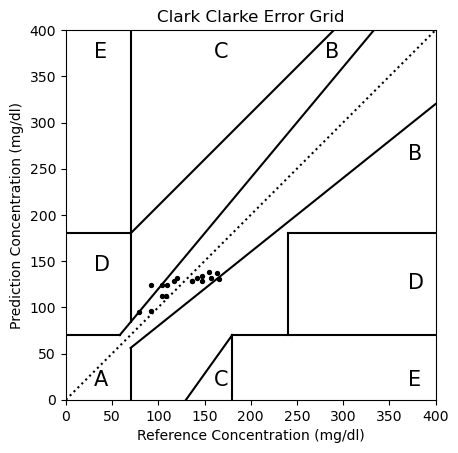

ARD by images:  [0.21344133 0.13024299 0.09243401 0.06200032 0.12821901 0.1601235
 0.34700394 0.19033873 0.16056663 0.20091328 0.04845825 0.05983694
 0.0753949  0.11069468 0.09342486 0.10119374 0.07752322 0.04069988]
Average ARD:  0.12736169


In [8]:
# KNN
# 50 bands, XGBoost
knn_reg = cuKNeighborsRegressor()
knn_reg.fit(X_train_selected, y_train)
y_pred_knn = cp.asnumpy(knn_reg.predict(X_test_selected))
mse_knn = mean_squared_error(y_test, y_pred_knn)
print(f"ARD by signatures: {ARD(y_pred_knn, y_test).mean()}" )
evaluate_image(test_data_selected, model=knn_reg)
ard = ard_image(test_data_selected, knn_reg)
print("ARD by images: ", ard)
print("Average ARD: ", ard.mean())

ARD by signatures: 0.23139360547065735


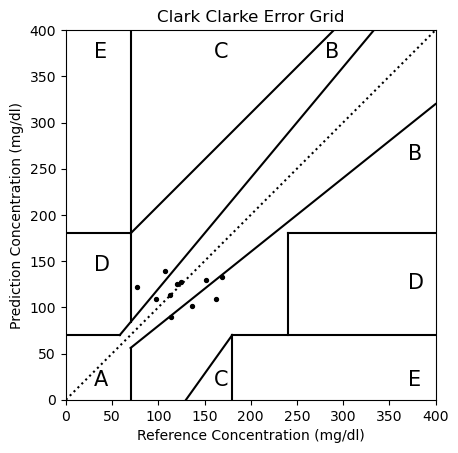

ARD by images:  [0.1151619  0.33123803 0.02123094 0.2130433  0.2975577  0.2619948
 0.14200687 0.21207024 0.0398201  0.58338934 0.00201997]
Average ARD:  0.20177574


In [11]:
# Random Forest
rf_reg = cuRF()
rf_reg.fit(X_train, y_train)
y_pred_rf = cp.asnumpy(rf_reg.predict(X_test))
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"ARD by signatures: {ARD(y_pred_rf, y_test).mean()}" )
evaluate_image(test_data, model=rf_reg)
ard = ard_image(test_data, rf_reg)
print("ARD by images: ", ard)
print("Average ARD: ", ard.mean())

ARD by signatures: 0.16138720512390137


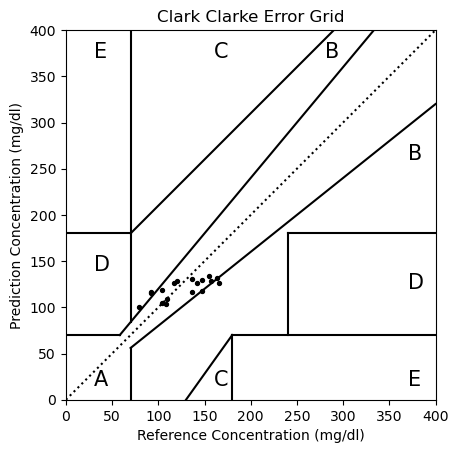

ARD by images:  [0.23502013 0.01236373 0.06448682 0.1484449  0.20708695 0.18318841
 0.25905257 0.13517772 0.19558443 0.26609266 0.27340832 0.04389958
 0.10900016 0.1331107  0.12171713 0.07964234 0.00199668 0.04053432]
Average ARD:  0.13943376


In [10]:
# Random Forest Selected
# 50 bands, F score
rf_reg = cuRF()
rf_reg.fit(X_train_selected, y_train)
y_pred_rf = cp.asnumpy(rf_reg.predict(X_test_selected))
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"ARD by signatures: {ARD(y_pred_rf, y_test).mean()}" )
evaluate_image(test_data_selected, model=rf_reg)
ard = ard_image(test_data_selected, rf_reg)
print("ARD by images: ", ard)
print("Average ARD: ", ard.mean())

ARD by signatures: 0.14882604777812958


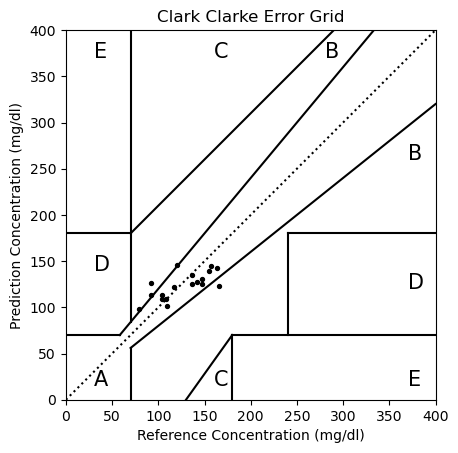

ARD by images:  [0.25531614 0.07537128 0.20581326 0.08714019 0.1517394  0.0780201
 0.3738507  0.0843458  0.12759702 0.237323   0.22750649 0.01785793
 0.10673595 0.10429069 0.11785164 0.03881999 0.04449438 0.00906332]
Average ARD:  0.1301743


In [9]:
# Random Forest Selected
# 50 bands, XGBoost
rf_reg = cuRF()
rf_reg.fit(X_train_selected, y_train)
y_pred_rf = cp.asnumpy(rf_reg.predict(X_test_selected))
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"ARD by signatures: {ARD(y_pred_rf, y_test).mean()}" )
evaluate_image(test_data_selected, model=rf_reg)
ard = ard_image(test_data_selected, rf_reg)
print("ARD by images: ", ard)
print("Average ARD: ", ard.mean())

ARD by signatures: 0.2252379059791565


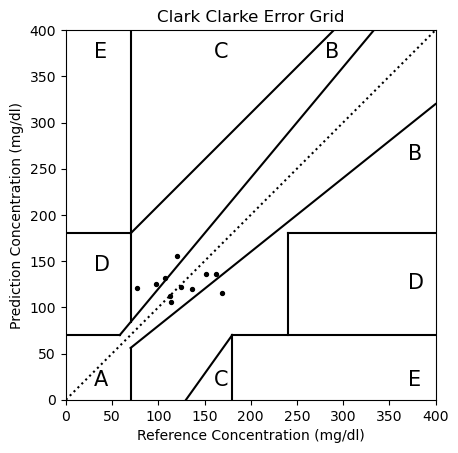

ARD by images:  [0.28801334 0.16287585 0.01910025 0.31896675 0.22106276 0.12125604
 0.10414402 0.06842649 0.28905767 0.56934375 0.00265264]
Average ARD:  0.19680905


In [12]:
# XGBoost
xgb_reg = XGBRegressor(device='cuda', tree_method='hist')
xgb_reg.fit(X_train, y_train)
y_pred_xgb = cp.asnumpy(xgb_reg.predict(X_test))
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print(f"ARD by signatures: {ARD(y_pred_xgb, y_test).mean()}" )
evaluate_image(test_data, model=xgb_reg)
ard = ard_image(test_data, xgb_reg)
print("ARD by images: ", ard)
print("Average ARD: ", ard.mean())

ARD by signatures: 0.13395708799362183


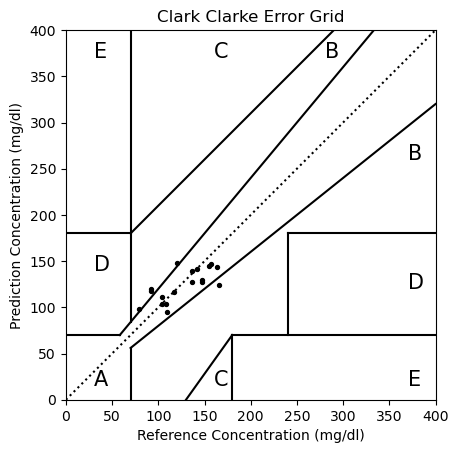

ARD by images:  [0.2521874  0.14054282 0.22216602 0.07223482 0.1397055  0.06068908
 0.30298695 0.06481494 0.12457366 0.23514494 0.28246543 0.01823244
 0.00483296 0.0659731  0.12069026 0.00196594 0.00778091 0.04619421]
Average ARD:  0.120176755


In [8]:
# XGBoost selected
# xgb_reg = XGBRegressor(
#             n_estimators=250
#            ,subsample=0.5236842105263158
#            ,random_state=42
#            ,tree_method='hist'
#            ,device='cuda'
#            ,n_job=-1
#            )
xgb_reg = XGBRegressor(tree_method='hist', device='cuda', n_job=-1)
xgb_reg.fit(X_train_selected, y_train)
y_pred_xgb = cp.asnumpy(xgb_reg.predict(X_test_selected))
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print(f"ARD by signatures: {ARD(y_pred_xgb, y_test).mean()}" )
evaluate_image(test_data_selected, model=xgb_reg)
ard = ard_image(test_data_selected, xgb_reg)
print("ARD by images: ", ard)
print("Average ARD: ", ard.mean())

ARD by signatures: 0.13395708799362183


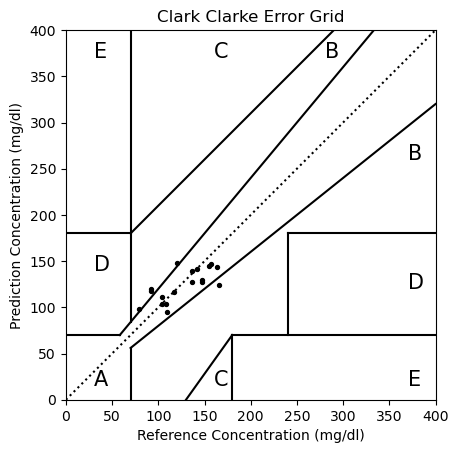

ARD by images:  [0.2521874  0.14054282 0.22216602 0.07223482 0.1397055  0.06068908
 0.30298695 0.06481494 0.12457366 0.23514494 0.28246543 0.01823244
 0.00483296 0.0659731  0.12069026 0.00196594 0.00778091 0.04619421]
Average ARD:  0.120176755


In [13]:
# 50 bands, XGBoost
# XGBoost selected
# xgb_reg = XGBRegressor(
#             n_estimators=250
#            ,subsample=0.5236842105263158
#            ,random_state=42
#            ,tree_method='hist'
#            ,device='cuda'
#            ,n_job=-1
#             )
xgb_reg = XGBRegressor(tree_method='hist', device='cuda', n_job=-1)
xgb_reg.fit(X_train_selected, y_train)
y_pred_xgb = cp.asnumpy(xgb_reg.predict(X_test_selected))
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print(f"ARD by signatures: {ARD(y_pred_xgb, y_test).mean()}" )
evaluate_image(test_data_selected, model=xgb_reg)
ard = ard_image(test_data_selected, xgb_reg)
print("ARD by images: ", ard)
print("Average ARD: ", ard.mean())

In [ ]:
# Load XGB model
model = load_model('./Models/XGB_regressor2_selected.model')
y_pred_xgb = cp.asnumpy(model.predict(X_test))
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print(f"ARD by signatures: {ARD(y_pred_xgb, y_test).mean()}" )
evaluate_image(test_data, model=model)
ard = ard_image(test_data, model)
print("ARD by images: ", ard)
print("Average ARD: ", ard.mean())

ARD by signatures: 0.1549784243106842


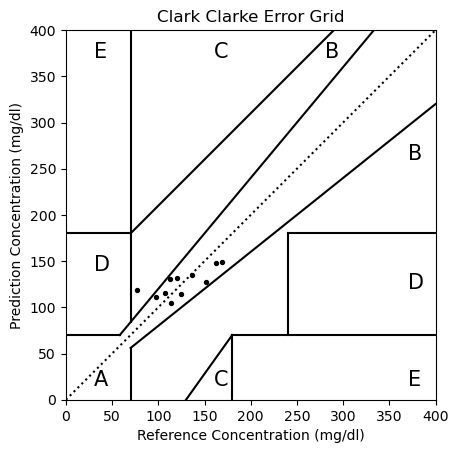

ARD by images:  [0.14394836 0.09036184 0.07737566 0.12168188 0.07562245 0.01385331
 0.15469396 0.07881323 0.09582508 0.5391375  0.15795957]
Average ARD:  0.14084299


In [13]:
# Support Vector Regressor
svr_reg = cuSVR()
svr_reg.fit(X_train, y_train)
y_pred_svr = cp.asnumpy(svr_reg.predict(X_test))
mse_svr = mean_squared_error(y_test, y_pred_svr)
print(f"ARD by signatures: {ARD(y_pred_svr, y_test).mean()}" )
evaluate_image(test_data, model=svr_reg)
ard = ard_image(test_data, svr_reg)
print("ARD by images: ", ard)
print("Average ARD: ", ard.mean())

ARD by signatures: 0.30658459663391113


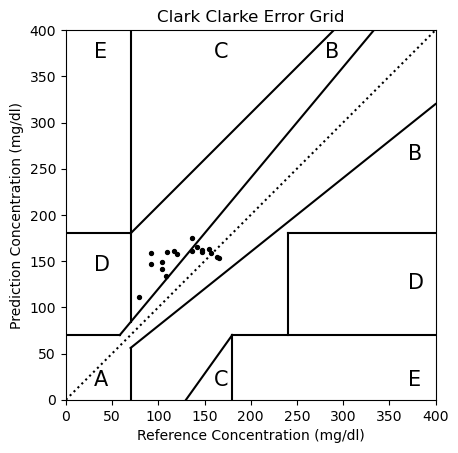

ARD by images:  [0.07677378 0.4499197  0.30621555 0.1745664  0.08294039 0.01585486
 0.7263407  0.42689213 0.05512528 0.401657   0.5972344  0.28178918
 0.16392665 0.05567091 0.09945198 0.37845042 0.35388118 0.24068931]
Average ARD:  0.27152112


In [7]:
# Support Vector Regressor
# 50 bands, XGBoost
svr_reg = cuSVR()
svr_reg.fit(X_train_selected, y_train)
y_pred_svr = cp.asnumpy(svr_reg.predict(X_test_selected))
mse_svr = mean_squared_error(y_test, y_pred_svr)
print(f"ARD by signatures: {ARD(y_pred_svr, y_test).mean()}" )
evaluate_image(test_data_selected, model=svr_reg)
ard = ard_image(test_data_selected, svr_reg)
print("ARD by images: ", ard)
print("Average ARD: ", ard.mean())

In [11]:
# Support Vector Regressor
# 50 bands, F score
svr_reg = cuSVR()
svr_reg.fit(X_train_selected, y_train)
y_pred_svr = cp.asnumpy(svr_reg.predict(X_test_selected))
mse_svr = mean_squared_error(y_test, y_pred_svr)
print(f"ARD by signatures: {ARD(y_pred_svr, y_test).mean()}" )
evaluate_image(test_data_selected, model=svr_reg)
ard = ard_image(test_data_selected, svr_reg)
print("ARD by images: ", ard)
print("Average ARD: ", ard.mean())

In [9]:
save_model(svr_reg, './Models/SVR_default_50selected_f.model')

In [ ]:
# Print the Mean Squared Error for each model
print("Mean Squared Error for Linear Regression:", mse_lin)
print("Mean Squared Error for Lasso Regression:", mse_lasso)
print("Mean Squared Error for Ridge Regression:", mse_ridge)
print("Mean Squared Error for Elastic Net:", mse_elastic)
print("Mean Squared Error for MLP:", mse_mlp)
print("Mean Squared Error for SVR:", mse_svr)
print("Mean Squared Error for XGBoost:", mse_xgb)
print("Mean Squared Error for PLS:", mse_pls)

In [ ]:
# # Trained PLS based on S1 and S2
# model = load_model('Models/PLS_regressor1.model')
# evaluate_image(test_data, model=model)

ARD by signatures: 0.16363548157257768


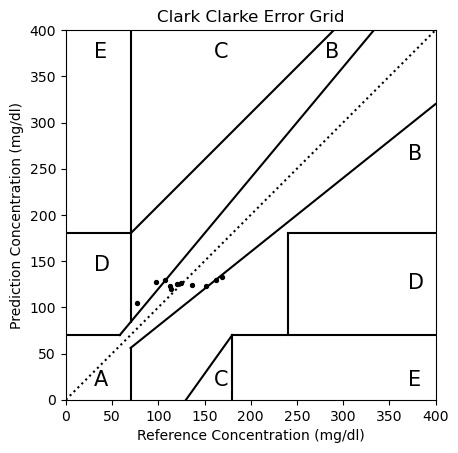

ARD by images:  [0.30739358 0.20599176 0.02014977 0.21658714 0.19879377 0.09466007
 0.18585318 0.05419235 0.03789252 0.3633579  0.09158597]
Average ARD:  0.16149618339625132


In [24]:
# PLSR default
plsr_test = PLSRegression()
plsr_test.fit(X_train, y_train)
y_pred_plsr_test = cp.asnumpy(plsr_test.predict(X_test))
mse_plsr_test = mean_squared_error(y_test, y_pred_plsr_test)
print(f"ARD by signatures: {ARD(y_pred_plsr_test, y_test).mean()}" )
evaluate_image(test_data, model=plsr_test)
ard = ard_image(test_data, plsr_test)
print("ARD by images: ", ard)
print("Average ARD: ", ard.mean())

ARD by signatures: 0.15800759220798366


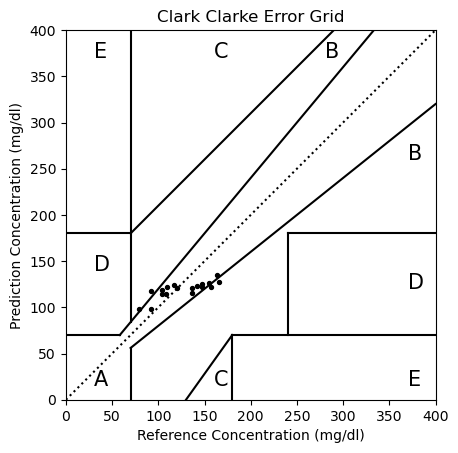

ARD by images:  [0.23321428 0.1110554  0.00399281 0.114249   0.1776159  0.22304615
 0.27814764 0.13814801 0.17408265 0.23755011 0.06635438 0.1580296
 0.13202601 0.18223837 0.15352534 0.0590285  0.0999892  0.06270591]
Average ARD:  0.14472218218085492


In [6]:
# PLSR
# Best parameter: tol: 1e-06, scale: False, n_components: 20, max_iter: 500
plsr_test = PLSRegression(n_components=25, scale=False, tol=1e-06, max_iter=500)
plsr_test.fit(X_train, y_train)
y_pred_plsr_test = cp.asnumpy(plsr_test.predict(X_test))
mse_plsr_test = mean_squared_error(y_test, y_pred_plsr_test)
print(f"ARD by signatures: {ARD(y_pred_plsr_test, y_test).mean()}" )
evaluate_image(test_data, model=plsr_test)
ard = ard_image(test_data, plsr_test)
print("ARD by images: ", ard)
print("Average ARD: ", ard.mean())

In [ ]:
step3 = np.asarray([ 8, 12, 19, 21, 26, 32, 33, 43, 48, 50, 55, 58, 59, 65]) * 3
step1 = np.asarray([ 24,  52,  58,  68,  76, 99, 105, 106, 127, 129, 144, 145, 146, 162, 177, 179])

step1 = selected_features
#step2 = selected_features * 2
print("step3: ", step3) 
print("step1: ", step1) 

In [ ]:
for image in test_data:
    print(image['label'])